### Comparing DBZ, ZDR and KDP (LP and Maesaka) methods.

In [2]:
import pyart
import glob
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import sys
import fiona
import geopandas as gpd
fiona.drvsupport.supported_drivers['lib?kml'] = 'rw' # enable KML support which is disabled by default
fiona.drvsupport.supported_drivers['LIBKML'] = 'rw' # enable KML support which is disabled by default



## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead
ERROR 1: PROJ: proj_create_from_database: Open of /ccsopen/home/braut/analysis-env2/share/proj failed


#### Select files

We are only reading a single sweep from a file with high rain rate.

In [3]:
hour = '19'
day = '25'
month = '08'
year = '2022'

files = sorted(glob.glob(f'/gpfs/wolf/atm124/proj-shared/gucxprecipradarS2.00/glue_files/{year}{month}_glued/xprecipradar_guc_volume_{year}{month}{day}-{hour}*'))

radar = pyart.io.read(files[-3])
radar = radar.extract_sweeps([0])

(-20.0, 20.0)

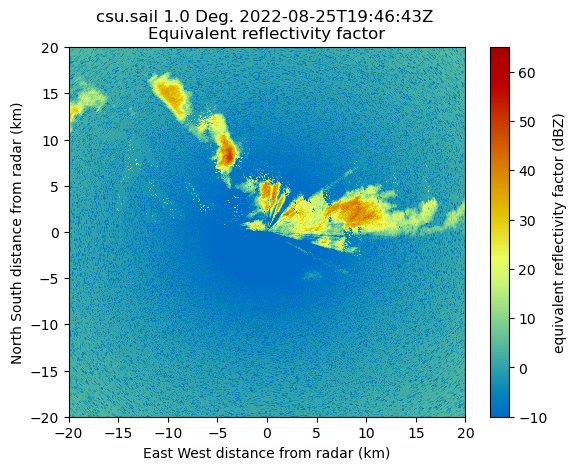

In [4]:
display = pyart.graph.RadarDisplay(radar)
display.plot('DBZ')
plt.xlim(-20, 20)
plt.ylim(-20, 20)

#### Create gatefilter

In [5]:
nyquist_value = radar.fields['VEL']['data'].max()
vel_texture = pyart.retrieve.calculate_velocity_texture(radar,
                                                        vel_field='VEL',
                                                        nyq=nyquist_value)

radar.add_field('velocity_texture', vel_texture, replace_existing=True)

phidp_texture = pyart.retrieve.texture_of_complex_phase(radar, phidp_field='PHIDP', phidp_texture_field='phidp_texture')

radar.add_field('phidp_texture', phidp_texture, replace_existing=True)

gatefilter = pyart.filters.GateFilter(radar)
gatefilter.exclude_above('phidp_texture', 30)
gatefilter.exclude_above('velocity_texture', 10)


### Compute KDP using  Maesaka method

In [6]:
kdp, _for_kdp, r_kdp = pyart.retrieve.kdp_maesaka(radar, gatefilter=gatefilter, refl_field='DBZhv',
                                                  psidp_field='PHIDP')
radar.fields['KDP_maesaka']=kdp



/ccsopen/home/braut/analysis-env2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


### Compute KDP using Giangrande LP method

In [7]:
PHIDP_LP, KDP_LP = pyart.correct.phase_proc_lp(radar, 0.0,
                                                   ncp_field='NCP',
                                                   refl_field='DBZ',
                                                   rhv_field='RHOHV',
                                                   phidp_field='PHIDP')

radar.fields['PHIDP_LP']=PHIDP_LP
radar.fields['KDP_LP']=KDP_LP

#### Get the fields in Numpy array

- Add offset to ZDR

In [13]:
dbz = radar.fields['DBZ']['data']
zdr = radar.fields['ZDR']['data']+2
kdp_maesaka = radar.fields['KDP_maesaka']['data']
kdp_lp = radar.fields['KDP_LP']['data']

(-20.0, 20.0)

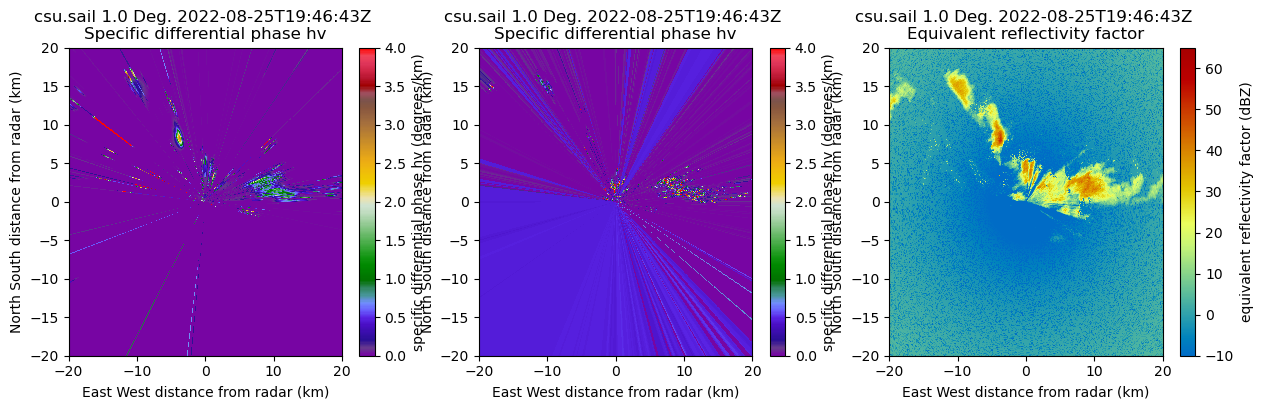

In [14]:
figure = plt.figure(figsize=(15, 4))
ax1=plt.subplot(1, 3, 1)
display = pyart.graph.RadarDisplay(radar)
display.plot('KDP_LP', ax=ax1, vmin=0, vmax=4, cmap='pyart_Carbone42',)
plt.xlim(-20, 20)
plt.ylim(-20, 20)

ax2=plt.subplot(1, 3, 2)
display.plot('KDP_maesaka', ax=ax2, vmin=0, vmax=4, cmap='pyart_Carbone42',)
plt.xlim(-20, 20)
plt.ylim(-20, 20)

ax3=plt.subplot(1, 3, 3)
display.plot('DBZ', ax=ax3)
plt.xlim(-20, 20)
plt.ylim(-20, 20)

#### Select reasonable DBZ range

In [15]:
dbz = dbz.flatten()
zdr = zdr.flatten()
kdp_lp = kdp_lp.flatten()
kdp_maesaka = kdp_maesaka.flatten()

dbz_sel = dbz[(dbz>10) * (dbz<60)]
zdr_sel = zdr[(dbz>10) * (dbz<60)]
kdp_lp_sel = kdp_lp[(dbz>10) * (dbz<60)]
kdp_maesaka_sel = kdp_maesaka[(dbz>10) * (dbz<60)]

Plot Distributions

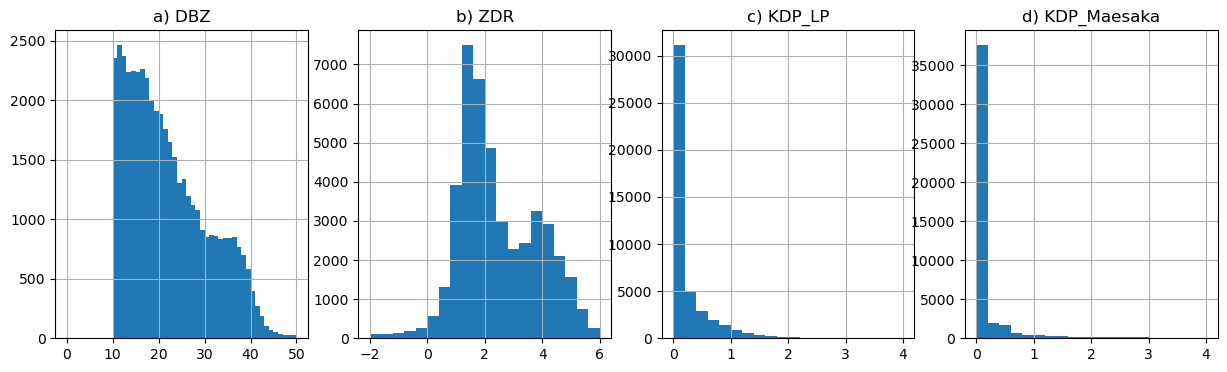

In [17]:
fig, ax = plt.subplots(1, 4, figsize=(15, 4))
ax[0].hist(dbz_sel, range=(0, 50), bins=50)
ax[0].set_title('a) DBZ')
ax[0].grid()
ax[1].hist(zdr_sel, range=(-2, 6), bins=20)
ax[1].set_title('b) ZDR')
ax[1].grid()
ax[2].hist(kdp_lp_sel, range=(0, 4), bins=20)
ax[2].set_title('c) KDP_LP')
ax[2].grid()
ax[3].hist(kdp_maesaka_sel, range=(0, 4), bins=20)
ax[3].set_title('d) KDP_Maesaka')
ax[3].grid()

Plot selected points

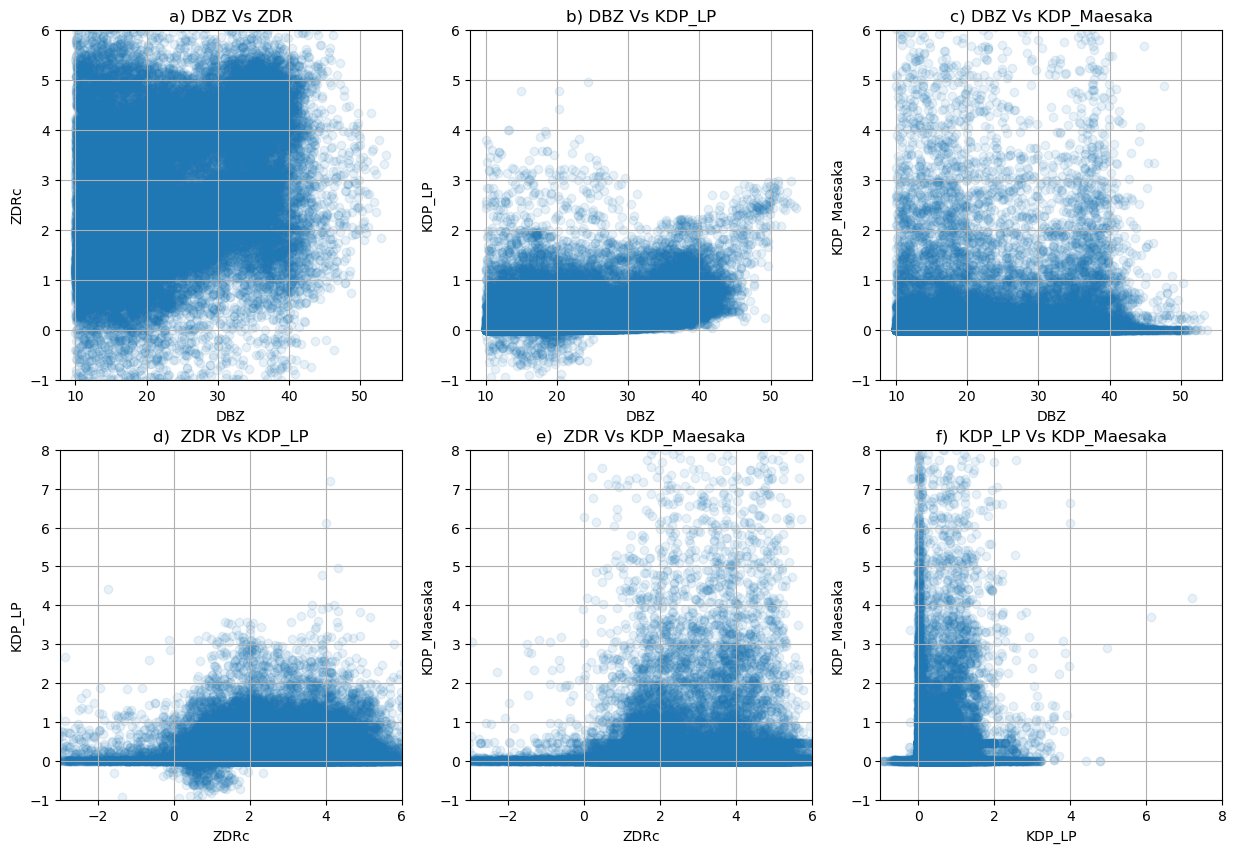

In [40]:


fig, ax = plt.subplots(2, 3, figsize=(15, 10))
ax[0, 0].scatter(dbz_sel, zdr_sel, alpha=0.1)
ax[0, 0].set_ylim(-1, 6)
ax[0, 0].set_xlabel('DBZ')
ax[0, 0].set_ylabel('ZDRc')
ax[0, 0].set_title('a) DBZ Vs ZDR')
ax[0, 0].grid()

ax[0, 1].scatter(dbz_sel, kdp_lp_sel, alpha=0.1)
ax[0, 1].set_ylim(-1, 6)
ax[0, 1].set_xlabel('DBZ')
ax[0, 1].set_ylabel('KDP_LP')
ax[0, 1].set_title('b) DBZ Vs KDP_LP')
ax[0, 1].grid()

ax[0, 2].scatter(dbz_sel, kdp_maesaka_sel, alpha=0.1)
ax[0, 2].set_ylim(-1, 6)
ax[0, 2].set_xlabel('DBZ')
ax[0, 2].set_ylabel('KDP_Maesaka')
ax[0, 2].set_title('c) DBZ Vs KDP_Maesaka')
ax[0, 2].grid()

ax[1, 0].scatter(zdr_sel, kdp_lp_sel,  alpha=0.1)
ax[1, 0].set_ylim(-1, 8)
ax[1, 0].set_xlim(-3, 6)
ax[1, 0].set_xlabel('ZDRc')
ax[1, 0].set_ylabel('KDP_LP')
ax[1, 0].set_title('d)  ZDR Vs KDP_LP')
ax[1, 0].grid()

ax[1, 1].scatter(zdr_sel, kdp_maesaka_sel, alpha=0.1)
ax[1, 1].set_ylim(-1, 8)
ax[1, 1].set_xlim(-3, 6)
ax[1, 1].set_xlabel('ZDRc')
ax[1, 1].set_ylabel('KDP_Maesaka')
ax[1, 1].set_title('e)  ZDR Vs KDP_Maesaka')
ax[1, 1].grid()

ax[1, 2].scatter(kdp_lp_sel, kdp_maesaka_sel, alpha=0.1)
ax[1, 2].set_ylim(-1, 8)
ax[1, 2].set_xlim(-1, 8)
ax[1, 2].set_xlabel('KDP_LP')
ax[1, 2].set_ylabel('KDP_Maesaka')
ax[1, 2].set_title('f)  KDP_LP Vs KDP_Maesaka')
ax[1, 2].grid()



(45296,)